# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city and country code based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
# Save config information.
weatherUrl = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
weatherQueryUrl = f"{weatherUrl}appid={api_key}&units={units}&q="
weatherQueryUrlAlternate = f"{weatherUrl}appid={api_key}&units={units}"

## Generate Cities List
NOTE:  citipy only looks for cities with at least 500 people.  This may impact our ability to find cities near the two poles if population density is not high enough.

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
locations = pd.DataFrame()

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=50)
lngs = np.random.uniform(low=-180.000, high=180.000, size=50)

# Add Northernmost city > 500 Reykjavík, Iceland
# Add Southernmost city > 500 Ushuaia, Argentina 
lats = np.append(lats, [64.128288, -54.7999992])
lngs = np.append(lngs, [-21.827774, -68.3000031])
lat_lngs = zip(lats, lngs)

latLngs = pd.DataFrame(list(zip(lats,lngs)), columns=["Latitude", "Longitude"])

# Identify nearest city for each lat, lng combination
i = 0
for lat_lng in lat_lngs:
    result = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city = result.city_name
    countryCode = result.country_code
   
    # add it to a our cities list
    locations.loc[i,"City"] = city
    locations.loc[i, "Country Code"] = countryCode

    locations.loc[i,"Latitude Random"] = lat_lng[0]
    locations.loc[i,"Longitude Random"] = lat_lng[1]
    i+=1
    

# Print the city count to confirm sufficient count
locations = locations.drop_duplicates(keep="first")
#len(locations)
#latLngs
locations

,City,Country Code,Latitude Random,Longitude Random
0,prokuplje,rs,43.053219,21.488124
1,batsfjord,no,72.296877,30.708922
2,concepcion del uruguay,ar,-32.142179,-59.154629
3,jalu,ly,27.519725,22.432696
4,chuy,uy,-47.386615,-40.111042
5,kroonstad,za,-27.604284,27.166599
6,bredasdorp,za,-63.557812,18.390450
7,atuona,pf,-2.998550,-130.217798
8,fortuna,us,37.808028,-139.916740
9,jamestown,sh,-11.740646,-8.758620


In [4]:
type(latLngs)
for index, lL in latLngs.iterrows():
    print(f"{index} = {lL['Latitude']}, {lL['Longitude']}")

0 = 43.053219258422445, 21.48812377237951
1 = 72.29687671071716, 30.708922331692634
2 = -32.14217882884519, -59.154629115639906
3 = 27.519724998359877, 22.43269614908513
4 = -47.38661537134109, -40.111041932937496
5 = -27.604284274634217, 27.166598984327777
6 = -63.557812294977225, 18.390450269239466
7 = -2.9985499487089555, -130.21779807807008
8 = 37.808028347909385, -139.91674017977837
9 = -11.740645630781984, -8.758619812790243
10 = 51.54580526267233, 60.83117867005268
11 = -47.94719790459927, -116.79669503705875
12 = 65.45707518576373, -141.04073841673755
13 = 29.31998049184304, -131.12562357927453
14 = 76.44510907647631, 148.60590403486975
15 = 11.81802895285442, -126.20111543177373
16 = 47.29207950308964, -91.66774411764939
17 = 86.58900520619389, -36.71167794756235
18 = 7.955826457936084, -177.36134862381587
19 = 70.25023534752788, -167.49626515063048
20 = 5.441900433747136, -125.82061379761723
21 = 40.37690625953087, -63.15452160479447
22 = -67.04561736716613, 28.88420796534001

## Latitude vs Longitude
Check for even distribution

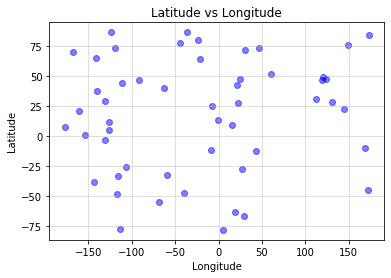

In [5]:
# Plot Latitude vs Longitude
plt.scatter(lngs, lats, c="b", alpha=0.5)
plt.title(f'Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLonDisbursement_RandomNoCityYet.png")
plt.show()

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
weather = pd.DataFrame()
weather

""


In [7]:
#index = 0
for index, location in locations.iterrows():
    time.sleep(2)
    response = requests.get(weatherQueryUrl + locations.loc[index]["City"] + "," + locations.loc[index]["Country Code"]).json()
    
    try:
       
        if (len(response)>0):
            weather.loc[index, "City"] = response["name"]
            weather.loc[index, "Cloudiness"] = response["clouds"]["all"]
            weather.loc[index, "Country"] = response["sys"]["country"]
            weather.loc[index, "Humidity"] = response["main"]["humidity"]
            weather.loc[index, "Lat"] = response["coord"]["lat"]
            weather.loc[index, "Lon"] = response["coord"]["lon"]
            weather.loc[index, "Temp"] = response["main"]["temp"]
            weather.loc[index, "Wind Speed"] = response["wind"]["speed"]
            weather.loc[index, "Latitude Random"] = location["Latitude Random"]
            weather.loc[index, "Longitude Random"] = location["Longitude Random"]
            
    except(KeyError, IndexError):
        print(f"Missing field/result for {locations.loc[index]['City']}, {locations.loc[index]['Country Code']}... skipping.")


Missing field/result for svetlyy, ru... skipping.
Missing field/result for vaitupu, wf... skipping.
Missing field/result for lata, sb... skipping.
Missing field/result for mataura, pf... skipping.
Missing field/result for belushya guba, ru... skipping.
Missing field/result for illoqqortoormiut, gl... skipping.
Missing field/result for yingzhong, cn... skipping.


In [8]:
weather = weather.dropna(axis=0, how='any', thresh=1, inplace=False)
weather

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed,Latitude Random,Longitude Random
0,Prokuplje,0.0,RS,57.0,43.23,21.59,10.00,6.20,43.053219,21.488124
1,Batsfjord,40.0,NO,80.0,70.63,29.72,3.13,1.00,72.296877,30.708922
2,Concepcion del Uruguay,15.0,AR,60.0,-32.48,-58.24,21.35,0.89,-32.142179,-59.154629
3,Jalu,0.0,LY,34.0,29.03,21.55,23.30,3.42,27.519725,22.432696
4,Chuy,0.0,UY,76.0,-33.69,-53.46,18.77,2.69,-47.386615,-40.111042
5,Kroonstad,0.0,ZA,40.0,-27.65,27.24,9.44,3.20,-27.604284,27.166599
6,Bredasdorp,100.0,ZA,76.0,-34.53,20.04,14.56,5.70,-63.557812,18.390450
7,Atuona,5.0,PF,72.0,-9.80,-139.03,26.17,5.39,-2.998550,-130.217798
8,Fortuna,1.0,US,63.0,40.60,-124.16,22.33,6.70,37.808028,-139.916740
9,Jamestown,100.0,SH,82.0,-15.94,-5.72,19.28,9.67,-11.740646,-8.758620


In [9]:
weatherAlternateMethod = pd.DataFrame()

for index, latLng in latLngs.iterrows():
    time.sleep(2)
#    print(weatherQueryUrlAlternate + "&lat=" + str(latLng['Latitude']) + "&lon=" + str(latLng['Longitude']))
    response = requests.get(weatherQueryUrlAlternate + "&lat=" + str(latLng["Latitude"]) + "&lon=" + str(latLng["Longitude"])).json()
    
    try:
       
        if (len(response)>0):
            weatherAlternateMethod.loc[index, "City"] = response["name"]
            weatherAlternateMethod.loc[index, "Cloudiness"] = response["clouds"]["all"]
            weatherAlternateMethod.loc[index, "Country"] = response["sys"]["country"]
            weatherAlternateMethod.loc[index, "Humidity"] = response["main"]["humidity"]
            weatherAlternateMethod.loc[index, "Lat"] = response["coord"]["lat"]
            weatherAlternateMethod.loc[index, "Lon"] = response["coord"]["lon"]
            weatherAlternateMethod.loc[index, "Temp"] = response["main"]["temp"]
            weatherAlternateMethod.loc[index, "Wind Speed"] = response["wind"]["speed"]
                
    except(KeyError, IndexError):
        print(f"Missing field/result for {latLng['Latitude']}, {latLng['Longitude']}... skipping.")


Missing field/result for 72.29687671071716, 30.708922331692634... skipping.
Missing field/result for 27.519724998359877, 22.43269614908513... skipping.
Missing field/result for -47.38661537134109, -40.111041932937496... skipping.
Missing field/result for -63.557812294977225, 18.390450269239466... skipping.
Missing field/result for -2.9985499487089555, -130.21779807807008... skipping.
Missing field/result for 37.808028347909385, -139.91674017977837... skipping.
Missing field/result for -11.740645630781984, -8.758619812790243... skipping.
Missing field/result for -47.94719790459927, -116.79669503705875... skipping.
Missing field/result for 29.31998049184304, -131.12562357927453... skipping.
Missing field/result for 76.44510907647631, 148.60590403486975... skipping.
Missing field/result for 11.81802895285442, -126.20111543177373... skipping.
Missing field/result for 86.58900520619389, -36.71167794756235... skipping.
Missing field/result for 7.955826457936084, -177.36134862381587... skippi

In [10]:
weatherAlternateMethod = weatherAlternateMethod.dropna(axis=0, how='any', thresh=5, inplace=False)
weatherAlternateMethod

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed
0,Bojnik,0.0,RS,57.0,43.05,21.49,9.18,6.20
2,Rosario del Tala,3.0,AR,65.0,-32.15,-59.16,24.07,0.86
5,Kroonstad,0.0,ZA,40.0,-27.61,27.17,9.44,3.20
10,Adamovka,0.0,RU,33.0,51.55,60.83,11.19,3.63
12,Eagle Village,84.0,US,63.0,65.46,-141.05,-0.79,2.03
16,Beaver Crossing,1.0,US,29.0,47.29,-91.67,15.42,4.60
24,Pala,100.0,TD,94.0,9.16,15.10,22.05,0.17
28,Nioumachoua,0.0,KM,75.0,-12.73,43.23,25.88,1.86
33,Three River Junction,1.0,US,25.0,44.22,-111.12,12.48,9.30
34,Xingong,29.0,CN,59.0,49.67,120.53,-3.19,3.43


In [11]:
print(f"Started with {len(lats)} random locations.")
print(f"Passing the random locations into the Open Weather API resulted in {len(weatherAlternateMethod['City'])} cities.")
print(f"However, using the citipy api to find a city > 500 population nearby resulted in {len(weather['City'])} cities.")

Started with 52 random locations.
Passing the random locations into the Open Weather API resulted in 19 cities.
However, using the citipy api to find a city > 500 population nearby resulted in 45 cities.


In [12]:
weather["Lat Diff"] = weather["Latitude Random"] - weather["Lat"]
weather["Lon Diff"] = weather["Longitude Random"] - weather["Lon"]
weather

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed,Latitude Random,Longitude Random,Lat Diff,Lon Diff
0,Prokuplje,0.0,RS,57.0,43.23,21.59,10.00,6.20,43.053219,21.488124,-0.176781,-0.101876
1,Batsfjord,40.0,NO,80.0,70.63,29.72,3.13,1.00,72.296877,30.708922,1.666877,0.988922
2,Concepcion del Uruguay,15.0,AR,60.0,-32.48,-58.24,21.35,0.89,-32.142179,-59.154629,0.337821,-0.914629
3,Jalu,0.0,LY,34.0,29.03,21.55,23.30,3.42,27.519725,22.432696,-1.510275,0.882696
4,Chuy,0.0,UY,76.0,-33.69,-53.46,18.77,2.69,-47.386615,-40.111042,-13.696615,13.348958
5,Kroonstad,0.0,ZA,40.0,-27.65,27.24,9.44,3.20,-27.604284,27.166599,0.045716,-0.073401
6,Bredasdorp,100.0,ZA,76.0,-34.53,20.04,14.56,5.70,-63.557812,18.390450,-29.027812,-1.649550
7,Atuona,5.0,PF,72.0,-9.80,-139.03,26.17,5.39,-2.998550,-130.217798,6.801450,8.812202
8,Fortuna,1.0,US,63.0,40.60,-124.16,22.33,6.70,37.808028,-139.916740,-2.791972,-15.756740
9,Jamestown,100.0,SH,82.0,-15.94,-5.72,19.28,9.67,-11.740646,-8.758620,4.199354,-3.038620


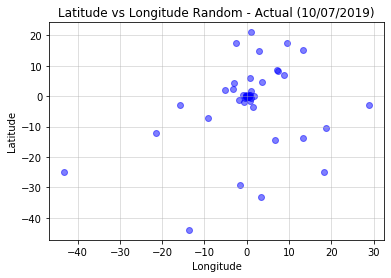

In [15]:
# Plot Latitude vs Longitude - Random - Actual
plt.scatter(weather["Lon Diff"], weather["Lat Diff"], c="b", alpha=0.5)
plt.title(f'Latitude vs Longitude Random - Actual ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LonLat_Diff.png")
plt.show()

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [16]:
# Grab the date
tupleTime = time.localtime() # get struct_time
timeString = time.strftime("%m/%d/%Y", tupleTime)
timeString

'10/07/2019'

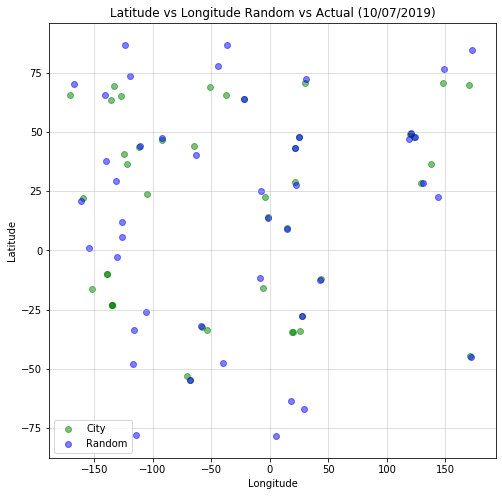

In [17]:
# Plot Latitude vs Longitude - Random vs Actual
plt.figure(figsize=(8,8))
plt.scatter(weather["Lon"], weather["Lat"], c="g", alpha=0.5, label="City")
plt.scatter(weather["Longitude Random"], weather["Latitude Random"], c="b", alpha=0.5, label="Random")
plt.title(f'Latitude vs Longitude Random vs Actual ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc="best")
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLon_RandomvsActual.png")
plt.show()

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

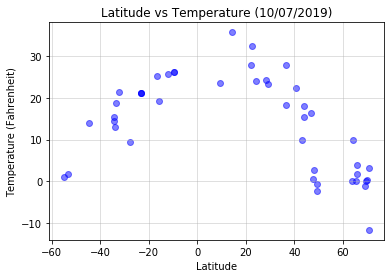

In [18]:
# Plot Latitude vs Max Temperature
plt.scatter(weather["Lat"], weather["Temp"], c="b", alpha=0.5)
plt.title(f'Latitude vs Temperature ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Temperature (Fahrenheit)')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsTemperature.png")
plt.show()

#### Latitude vs. Humidity Plot

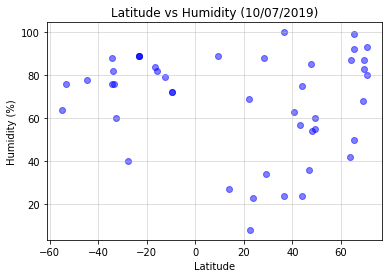

In [19]:
# Plot Latitude vs Humidity
plt.scatter(weather["Lat"], weather["Humidity"], c="b", alpha=0.5)
plt.title(f'Latitude vs Humidity ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsHumidity.png")
plt.show()

#### Latitude vs. Cloudiness Plot

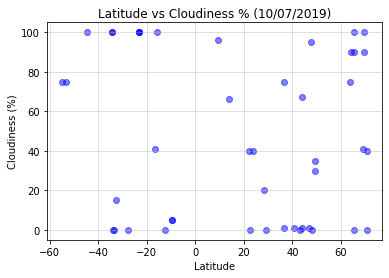

In [20]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lat"], weather["Cloudiness"], c="b", alpha=0.5)
plt.title(f'Latitude vs Cloudiness % ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsCloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

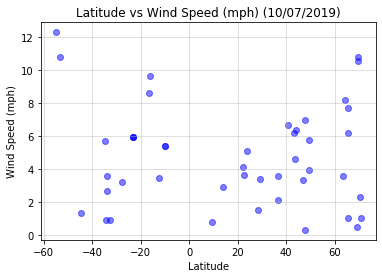

In [21]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lat"], weather["Wind Speed"], c="b", alpha=0.5)
plt.title(f'Latitude vs Wind Speed (mph) ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsWindSpeed.png")
plt.show()

## Longitude vs Latitude
Checking for relatively even distribution of resulting cities.

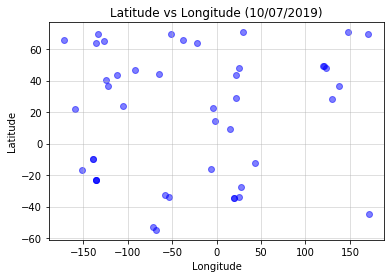

In [22]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lon"], weather["Lat"], c="b", alpha=0.5)
plt.title(f'Latitude vs Longitude ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLonDisbursement_Final.png")
plt.show()

## Notes
* citipy only considers cities with at least 500 in their population.  This has a potential for eliminating cities that might be closer to the North Pole or South Pole, resuling in fewer data points at the latitude extremes.
* citipy is a limited interface that only returns city and country code, but often there is more than one city in a country with the same name, which could result in multiple responses when calling the open weather map api.  
    - While I assumed the first response was the best, this could be improved upon by comparing each result to the original latitude and longitude to select the correct city.
* Based on multiple cities within the same country sharing a name, I tried using the latitude and longitude directly when calling the open weather map api.  I expected to get a higher percetage of successful results, but instead I received fewer.  Because our Latitude and Longitude are randomly generated they are not necessarily in an area that reports on weather.  The usage of the citipy api improves the probably of finding a result in the open weather map api, although there is some loss in data in both approaches.
* Plotting random vs city locations shows very few cities near the North and especially the South Pole.